# Titration Experiment

In [1]:
#############################
#   Experiment parameters   #
#############################
ROOT_DIR = '/analysis/gh-msun/'
PROJECT_SLUG = '2023_06_26_SRT_deconvolution_MS'
EXPERIMENT = 't_subset_blueprint_2m'
TITRATING_CELLTYPE = 't_effector'
TITRATING_CELLTYPE_ATLAS = 'immune_t_effector' # cell type name in atlas different
BACKGROUND = 'wholeblood' # background: uniform / wholeblood 
N_REPLICATES = 20 # number of replicates for each mixture
SEED = 888 # need to change for different experiment
TOTAL_READS_TO_SAMPLE = 2000000

# make sure the orders of the two list match
CELLTYPES = ['t_effector',
             't_reg', 
             't_naive',
             'Blueprint-B',
             'Blueprint-NK',
             'Blueprint-Mono',
             'Blueprint-Neutro']
ABRIDGED_NAMES = ['Teff', 'Treg', 'Tnaive', 'B', 'NK', 'MONO', 'NEUTRO'] # for directory name

# TITRATION_LIST = [0.10, 0.08, 0.06, 0.04, 0.02, 0.01, 
#                   0.008, 0.006, 0.004, 0.002, 0.001, 0]


# # proportion of cells in real whole blood (sum to 1)
# WHOLE_BLOOD_ABUNDANCE = {'Blueprint-B':0.06,
#                          'Blueprint-Mono':0.09,
#                          'Blueprint-Neutro':0.57,
#                          't_naive':0.16+0.07,
#                          'Blueprint-NK':0.05}
    

In [2]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import functools
import os
import regex as re
import random
import importlib
import sys

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import IntegerType, LongType, ArrayType, StringType, DoubleType
from pyspark.sql.functions import udf, explode, broadcast, count, lit, length, col
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType

# UPDATE HOME!
os.environ["SPARK_HOME"] = "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark"
# THIS needs to be set-up before running the notebook
os.environ["SPARK_LOCAL_DIRS"] = "/temp"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

spark_conf = SparkConf()
spark_conf.set("spark.ui.showConsoleProgress", "True")
spark_conf.set("spark.executor.instances", "2")
spark_conf.set("spark.executor.cores", "2")
spark_conf.set("spark.executor.memory", "16g")
spark_conf.set("spark.driver.memory", "64g")
spark_conf.set("spark.driver.maxResultSize", "32g")
spark_conf.set("spark.parquet.filterPushdown", "true")
spark_conf.set("spark.local.dir", "/temp")
spark_conf.getAll()

sc = SparkContext(conf=spark_conf)
sc.setLogLevel("ERROR")
spark = SparkSession(sc)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_context('talk')

/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [3]:
#---Local paths---#
PROJECT_DIR = ROOT_DIR + f'projects/{PROJECT_SLUG}/'

#---Load all custom scripts---#
SCRIPT_DIR = PROJECT_DIR + 'scripts/'
sys.path.append(SCRIPT_DIR)

import create_mixture as cm
import score_matrix as sm
import deconvolution as dcnv
import helper as hlpr

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
importlib.reload(cm)
importlib.reload(sm)
importlib.reload(dcnv)
importlib.reload(hlpr)

<module 'helper' from '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/helper.py'>

In [5]:
CELLTYPES = ['t_effector', 
             't_reg',
             't_naive',
             'Blueprint-B',
             'Blueprint-NK',
             'Blueprint-Mono',
             'Blueprint-Neutro']

ABRIDGED_NAMES = ['Teff', 'Treg', 'Tnaive', 'B', 'NK', 'MONO', 'NEUTRO'] # for directory name

TITRATION_LIST = [0.20, 0.15, 0.10, 0.08, 0.06, 0.04, 0.02, 0.01, 
                  0.008, 0.006, 0.004, 0.002, 0.001, 0] # % of total T-cells

# background cell type proportion (T is 23%)
WHOLE_BLOOD_ABUNDANCE = {'B':0.06,
                         'Mono':0.09,
                         'Neutro':0.57,
                         'NK':0.05}

# background: % of total T-cells (multipy with 0.2)
WHOLE_BLOOD_ABUNDANCE_T = {'t_naive':0.99,
                           't_reg':0.01}

PROPORTIONS = []
treg_titrating_proprotions = [] 
teff_titrating_proprotions = []
tnai_titrating_proprotions = []

for t, alpha in enumerate(TITRATION_LIST):  
    
    # T cell total to be 23 % 
    proportion_teff = 0.23 * alpha  # alpha is the titrating proportion
    proportion_treg = 0.23 * (1-alpha) * WHOLE_BLOOD_ABUNDANCE_T['t_reg'] 
    proportion_tnai = 0.23 * (1-alpha) * WHOLE_BLOOD_ABUNDANCE_T['t_naive'] 
    
    treg_titrating_proprotions.append(proportion_treg)
    teff_titrating_proprotions.append(proportion_teff)
    tnai_titrating_proprotions.append(proportion_tnai)
    
    proportion = [proportion_teff, 
                  proportion_treg, 
                  proportion_tnai,
                  WHOLE_BLOOD_ABUNDANCE['B'],
                  WHOLE_BLOOD_ABUNDANCE['NK'],
                  WHOLE_BLOOD_ABUNDANCE['Mono'],
                  WHOLE_BLOOD_ABUNDANCE['Neutro']]
    
    PROPORTIONS.append(proportion)


In [6]:
teff_titrating_proprotions

[0.046000000000000006,
 0.0345,
 0.023000000000000003,
 0.0184,
 0.0138,
 0.0092,
 0.0046,
 0.0023,
 0.00184,
 0.0013800000000000002,
 0.00092,
 0.00046,
 0.00023,
 0.0]

## Create mixture

In [7]:
############################
#   Parameters and paths   # 
############################
EXPERIMENT_DIR = PROJECT_DIR + f'output/experiment/{EXPERIMENT}/'
EXPERIMENT_NAME = f'{TITRATING_CELLTYPE}-{BACKGROUND}/'
PARQUET_PATH = PROJECT_DIR + 'output/mixture_source/t_subset_mixture_source/'
EXPERIMENT_CELLTYPE_DIR = EXPERIMENT_DIR + f'{EXPERIMENT_NAME}/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR + 'mixture/'


In [ ]:
%%time
# load parquet files for each celltype & count rows
parquet_df, total_reads_per_celltype = cm.load_parquet_dataframe(parquet_path=PARQUET_PATH,
                                                                  cell_types=CELLTYPES,
                                                                  spark=spark,
                                                                  verbose=True)

# mix cell types for each proportion set
cm.mix_celltypes_multiple_proportions(parquet_df=parquet_df,
                                       total_reads_per_celltype=total_reads_per_celltype,
                                    #    n=len(TITRATION_LIST), 
                                       n=N_REPLICATES,
                                       cell_types=CELLTYPES, 
                                       cell_type_abridged_name=ABRIDGED_NAMES, 
                                       total_reads_to_sample=TOTAL_READS_TO_SAMPLE, 
                                       list_of_proportions=PROPORTIONS, 
                                       seed=SEED, 
                                       result_path=RESULT_PATH, 
                                       spark=spark,
                                       verbose=False, 
                                       save=True)

>>> Load parquet files and count rows... <<<
----------> Loading cell type: t_effector
----------> Loading cell type: t_reg
----------> Loading cell type: t_naive
----------> Loading cell type: Blueprint-B
----------> Loading cell type: Blueprint-NK
----------> Loading cell type: Blueprint-Mono
----------> Loading cell type: Blueprint-Neutro
>>> Complete. <<< 

>>> Start mixing... <<<
--> PROPORTION: [0.046000000000000006, 0.0018400000000000003, 0.18216000000000002, 0.06, 0.05, 0.09, 0.57]
----------> Creating mixture 0... 
----------> Creating mixture 1... 
----------> Creating mixture 2... 
----------> Creating mixture 3... 
----------> Creating mixture 4... 
----------> Creating mixture 5... 
----------> Creating mixture 6... 
----------> Creating mixture 7... 
----------> Creating mixture 8... 
----------> Creating mixture 9... 
----------> Creating mixture 10... 
----------> Creating mixture 11... 
----------> Creating mixture 12... 
----------> Creating mixture 13... 
---------->

## Compute score matrix

In [ ]:
############################
#   Parameters and paths   # 
############################

FILTER_CG_COUNT = 3
FILTER_CG_COUNT_REGION = 1

REGIONS = 'deconvolution_v2.v23_conv.with_cpg_index'
REGION_BED_COLS = [
    'region_chr', 'region_start', 'region_end', 
    'region_cpg_index_min', 'region_cpg_index_max', 'region_id'
]

# Regions
REGION_PATH = (
    PROJECT_DIR + '/stage/panel_data/{regions}.bed'
).format(regions=REGIONS)

# CpG map; genomic coordinate to CpG index;
CPG_MAP_PATH = PROJECT_DIR + '/stage/cpg_loci/cpg_loci_hg19.combined_annot.tsv.gz'

#--- Where to store results
PATH_TO_MIXTURE_DIR = EXPERIMENT_CELLTYPE_DIR + 'mixture/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR


In [ ]:
cpg_map = pd.read_csv(CPG_MAP_PATH, usecols=['chr', 'start', 'end', 'cpg_index', 'cpg_index_hg38'], sep='\t')

In [ ]:
%%time
ridxs = ~cpg_map['cpg_index_hg38'].isna()
hg19_hg38_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index'], cpg_map[ridxs]['cpg_index_hg38'].astype(int)))
hg38_hg19_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index_hg38'].astype(int), cpg_map[ridxs]['cpg_index']))

In [ ]:
region_df = pd.read_csv(REGION_PATH, sep='\t', usecols=range(0, 6), names=REGION_BED_COLS)

region_df['region_cpg_index_max'] -= 1
region_df.sort_values('region_cpg_index_min', inplace=True)
region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min'].map(hg19_hg38_map)
region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max'].map(hg19_hg38_map)

region_df.shape[0], region_df['region_id'].nunique()

In [ ]:
ridxs = ~region_df['region_cpg_index_min_hg38'].isna()
ridxs &= ~region_df['region_cpg_index_max_hg38'].isna()
region_df = region_df[ridxs].copy()
region_df.shape[0], region_df['region_id'].nunique()

In [ ]:
cg_count_hg19 = region_df['region_cpg_index_max']-region_df['region_cpg_index_min'] + 1
cg_count_hg38 = region_df['region_cpg_index_max_hg38']-region_df['region_cpg_index_min_hg38'] + 1
ridxs = (cg_count_hg19==cg_count_hg38)
ridxs &= (cg_count_hg19>=FILTER_CG_COUNT_REGION)
region_df = region_df[ridxs].copy()
region_df.shape[0], region_df['region_id'].nunique()

In [ ]:
region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min_hg38'].astype(int)
region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max_hg38'].astype(int)

In [ ]:
### Restrict to immune regions
#-------------- CHANGE HERE FOR DIFFERENT REGION SUBSET ----------------------
# BLUEPRINT immune regions
ATLAS_PATH = PROJECT_DIR + f'/output/reference/deconv_inhouse_v2.t_subset.atlas.tsv.gz'
atlas = pd.read_csv(ATLAS_PATH, sep='\t')
subset_region_set = set(atlas.region_id)
#-----------------------------------------------------------------------------

# filter regions down to regions of interest
region_df = region_df[region_df['region_id'].isin(subset_region_set)]
region_df.head()

In [ ]:
%%time

PAT_COLS = [
    'molecule_id', 'chr', 'number_molecules',
    'cpg_index_min', 'cpg_index_max', 'pat_string', 'region_id', 'region_cpg_index_min', 'region_cpg_index_max'
]

QUANTILES = [0.1, 0.25, 0.75, 0.9]
KMERS = [1, 3, 4]
RATES_LEQ = [0.25]
RATES_GEQ = [0.75]

RETURN_SCHEMA = StructType()\
    .add('region_id', 'string')\
    .add('number_molecules', 'integer')\
    .add('meth_k1', 'integer')\
    .add('unmeth_k1', 'integer')\
    .add('total_k1', 'integer')\
    .add('meth_k3', 'integer')\
    .add('unmeth_k3', 'integer')\
    .add('total_k3', 'integer')\
    .add('meth_k4', 'integer')\
    .add('unmeth_k4', 'integer')\
    .add('total_k4', 'integer')\
    .add('frac_alpha_leq_25pct', 'float')\
    .add('frac_alpha_geq_75pct', 'float')

compute_frag_scores_udf = sm.compute_frag_scores(cpg_number_cutoff=FILTER_CG_COUNT, schema=RETURN_SCHEMA, kmers=KMERS, rates_leq=RATES_LEQ, rates_geq=RATES_GEQ)


# compute methyl score for are parquet files
sm.score_matrix_from_mixture_directory(path_to_mixture_dir = PATH_TO_MIXTURE_DIR, 
                                       result_path = RESULT_PATH, 
                                       pat_cols = PAT_COLS, 
                                       batch_size = 20, 
                                       schema = RETURN_SCHEMA, 
                                       spark=spark,
                                       compute_frag_scores_udf=compute_frag_scores_udf,
                                       save=True, 
                                       verbose=False)

## Deconvolution

In [8]:
############################
#   Parameters and paths   # 
############################

FILTER_COV = 20

SCORE_VAR = 'frac_alpha_leq_25pct'

# Reference matrix
ATLAS_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.t_subset_same.atlas.tsv.gz'
REGION_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.t_subset_same.region_to_ref_celltype.tsv.gz'

# Methylation score matrix
SCORE_DIR = EXPERIMENT_CELLTYPE_DIR + 'methyl_score/'


In [9]:
SCORE_DIR

'/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/t_subset_blueprint_2m/t_effector-wholeblood//methyl_score/'

In [10]:
atlas = pd.read_csv(ATLAS_PATH, sep='\t',index_col=None)
atlas = atlas.set_index('region_id')
atlas.columns.name = 'ref_celltype'
atlas.shape

ref_region_df = pd.read_csv(REGION_PATH, sep='\t')

atlas = atlas.loc[ref_region_df['region_id'], :].copy()
atlas.shape

(324, 11)

In [11]:
%%time

deconvolution_nnls = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR, 
                                                                          score_type=SCORE_VAR, 
                                                                          atlas=atlas, 
                                                                          match=False)

deconvolution_naive = dcnv.compute_deconvolution_from_methyl_score_dir_naive(path_to_methyl_score_dir=SCORE_DIR, 
                                                                             filter_cov=FILTER_COV, 
                                                                             score_var=SCORE_VAR, 
                                                                             ref_region_df=ref_region_df)


CPU times: user 6.08 s, sys: 319 ms, total: 6.4 s
Wall time: 6.43 s


In [12]:
SCORE_DIR

'/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/t_subset_blueprint_2m/t_effector-wholeblood//methyl_score/'

In [13]:

# dcnv.boxplot_titration_combined(list_of_deconvolution_dfs_naive=deconvolution_naive,
#                        list_of_deconvolution_dfs_nnls=deconvolution_nnls,
#                       cell_type=TITRATING_CELLTYPE_ATLAS,
#                       true_proportions=[round(x, 4) for x in teff_titrating_proprotions]
#                       )

In [14]:
# dcnv.boxplot_titration_zoom_combined(list_of_deconvolution_dfs_naive=deconvolution_naive,
#                        list_of_deconvolution_dfs_nnls=deconvolution_nnls,
#                       cell_type=TITRATING_CELLTYPE_ATLAS,
#                       true_proportions=[round(x, 4) for x in treg_titrating_proprotions]
#                       )

In [15]:
importlib.reload(cm)
importlib.reload(sm)
importlib.reload(dcnv)
importlib.reload(hlpr)

<module 'helper' from '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/helper.py'>

In [16]:
TITRATING_CELLTYPE_ATLAS

'immune_t_effector'

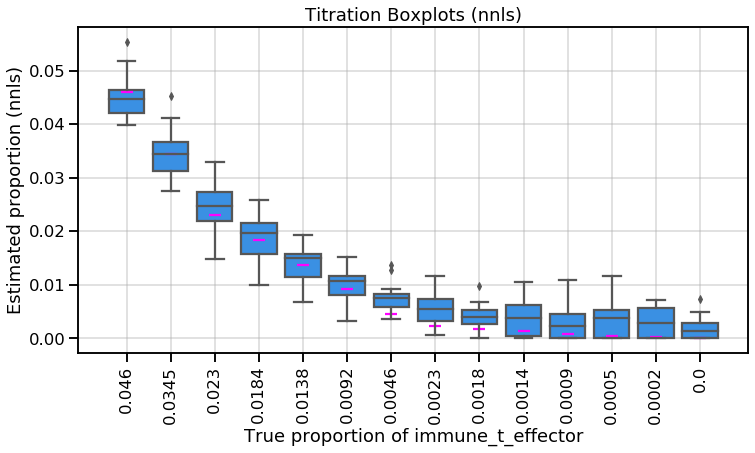

In [17]:
deconvolution_nnls = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR, 
                                                                          score_type=SCORE_VAR, 
                                                                          atlas=atlas, 
                                                                          match=False)

dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=[round(x, 4) for x in teff_titrating_proprotions],
                      deconvolution_method_name='nnls'
                      )

In [18]:
SCORE_DIR

'/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/t_subset_blueprint_2m/t_effector-wholeblood//methyl_score/'

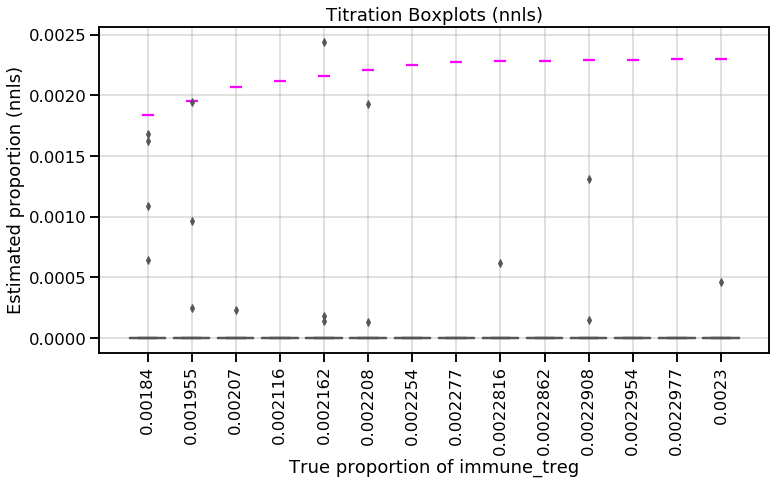

In [19]:
deconvolution_nnls = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR, 
                                                                          score_type=SCORE_VAR, 
                                                                          atlas=atlas, 
                                                                          match=False)

dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type='immune_treg',
                      true_proportions=[round(x, 8) for x in treg_titrating_proprotions],
                      deconvolution_method_name='nnls'
                      )

In [20]:
SCORE_DIR

'/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/t_subset_blueprint_2m/t_effector-wholeblood//methyl_score/'

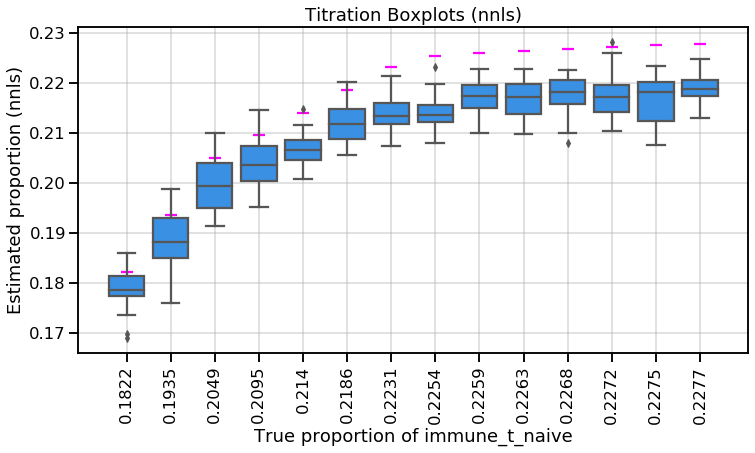

In [21]:
deconvolution_nnls = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR, 
                                                                          score_type=SCORE_VAR, 
                                                                          atlas=atlas, 
                                                                          match=False)

dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type='immune_t_naive',
                      true_proportions=[round(x, 4) for x in tnai_titrating_proprotions],
                      deconvolution_method_name='nnls'
                      )

In [22]:
SCORE_DIR

'/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/t_subset_blueprint_2m/t_effector-wholeblood//methyl_score/'

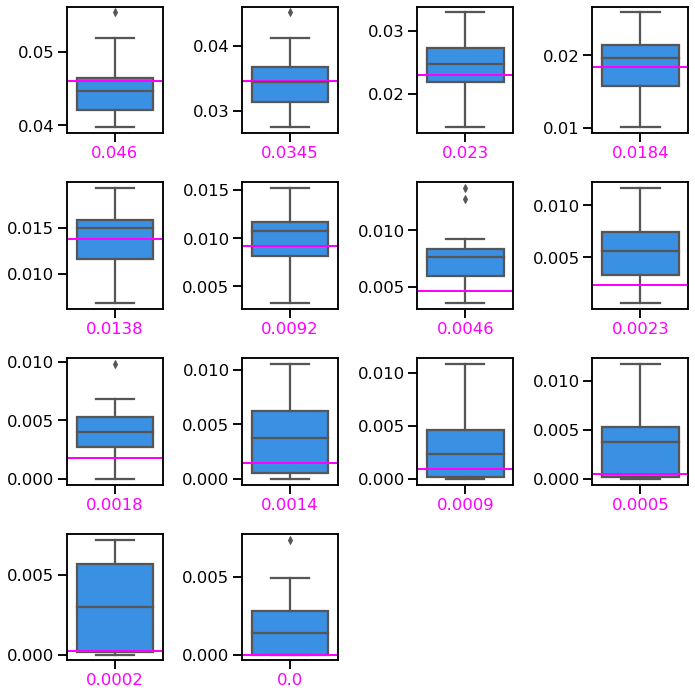

In [23]:
dcnv.boxplot_titration_zoom(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=[round(x, 4) for x in teff_titrating_proprotions],
                      deconvolution_method_name='nnls')

In [24]:
SCORE_DIR

'/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/t_subset_blueprint_2m/t_effector-wholeblood//methyl_score/'

In [16]:
%%time

CELLTYPES = ['t_effector',
             't_reg']

# load score data from all cell types
deconvolution_nnls = []
deconvolution_naive = []

TITRATION_LIST = teff_titrating_proprotions
SCORE_VAR = 'frac_alpha_leq_25pct'
FILTER_COV = 20

for celltype in CELLTYPES: 
    EXPERIMENT_NAME = f'{celltype}-{BACKGROUND}/'            # <-- iterate over this
    EXPERIMENT_CELLTYPE_DIR = EXPERIMENT_DIR + f'{EXPERIMENT_NAME}/'
    SCORE_DIR = EXPERIMENT_CELLTYPE_DIR + 'methyl_score/'

    # iterate nnls deconvolition on each score_df
    deconv_nnls = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR, 
                                                                          score_type=SCORE_VAR, 
                                                                          atlas=atlas, 
                                                                          match=False)
    
     # iterate naive deconvolution on each score_df
    deconv_naive = dcnv.compute_deconvolution_from_methyl_score_dir_naive(path_to_methyl_score_dir=SCORE_DIR, 
                                                                             filter_cov=FILTER_COV, 
                                                                             score_var=SCORE_VAR, 
                                                                             ref_region_df=ref_region_df)
    
    deconvolution_nnls.append(deconv_nnls)
    deconvolution_naive.append(deconv_naive)

CPU times: user 9.07 s, sys: 20.2 ms, total: 9.09 s
Wall time: 9.09 s


In [17]:
# import copy

# TRUE_PROPORTIONS = copy.deepcopy(TITRATION_LIST)

# for i in range(len(TITRATION_LIST )):
#     last_item = TITRATION_LIST.pop()
#     TITRATION_LIST.insert(i, last_item)

# TITRATION_LIST

In [ ]:
TITRATION_LIST

In [20]:
CELLTYPE_ATLAS = ['immune_t_effector', 'immune_treg']

[0.      0.00023 0.00046 0.00092 0.00138 0.00184 0.0023  0.0046  0.0092
 0.0138  0.0184  0.023   0.0345  0.046  ]
[0.55 0.7  0.6  0.7  0.55 0.8  0.9  1.   1.   1.   1.   1.   1.   1.  ]
[0.      0.00023 0.00046 0.00092 0.00138 0.00184 0.0023  0.0046  0.0092
 0.0138  0.0184  0.023   0.0345  0.046  ]
[0.   0.   0.   0.   0.   0.   0.   0.   0.5  0.95 1.   1.   1.   1.  ]


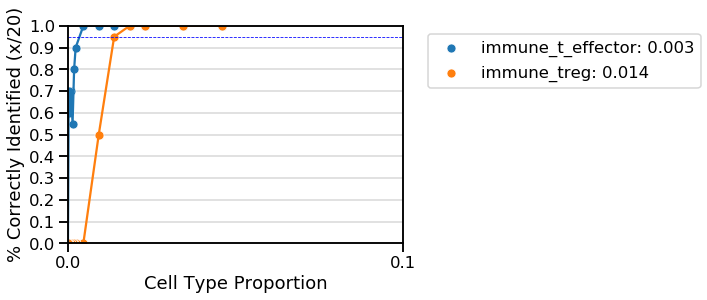

In [21]:
CELLTYPE_ATLAS_ = CELLTYPE_ATLAS
deconvolution_naive_ = deconvolution_naive
deconvolution_nnls_ = deconvolution_nnls
TRUE_PROPORTIONS = teff_titrating_proprotions

data = []
lod95_value = []

# <- start loop
for celltype in CELLTYPE_ATLAS_:
    
    CELL_TYPE = celltype

    celltype_idx = CELLTYPE_ATLAS_.index(CELL_TYPE)
    testing = deconvolution_nnls_[celltype_idx]

    ###### ----- correct proportion
    # detect with close to true proportion
    EPS = TITRATION_LIST

    p_correct = []

    testing = deconvolution_nnls_[celltype_idx]

    # for i in range(0,len(testing)):
    #     df = testing[i]
    #    #  print(df.head())
    #     m, n = df.shape
    #     eps = EPS[i] * 0.3
    #     true_p = TRUE_PROPORTIONS[i]
    #     true_p_min = true_p - eps 
    #     true_p_max = true_p + eps
    #     phat = df[df.index == CELL_TYPE]
    #     phat = phat.values.squeeze()
    #     phat_boolean = [(true_p_min <= x <= true_p_max) for x in phat]
    #     p_correct.append(sum(phat_boolean) / n)


    DETECTION_THRESHOLD = 0.005

    p_detect = []

    for df in testing:
        m, n = df.shape
        phat = df[df.index == CELL_TYPE]
        phat_boolean = phat > DETECTION_THRESHOLD
        p_detected = sum(phat_boolean.values.squeeze()) / n
        p_detect.append(p_detected)

    p_correct = p_detect


    ###### ----- plotting

    # Replace these with your data
    x_values = TRUE_PROPORTIONS
    y_values = p_correct  #  p_correct #
    
    data.append((x_values, y_values))

    # Sorting the x_values and y_values in the order of x_values
    sorted_indices = np.argsort(x_values)
    x_values_sorted = np.array(x_values)[sorted_indices]
    y_values_sorted = np.array(y_values)[sorted_indices]
    
    print(x_values_sorted)
    print(y_values_sorted)
    
    if x_values_sorted[0] == 0:
        y_values_sorted[0] = 0

    # Interpolating to find the x-value
    y_target = 0.95
    x_target = np.interp(y_target, y_values_sorted, x_values_sorted)
    lod95_value.append(x_target)



for i, (x_values, y_values) in enumerate(data):
    name = CELLTYPE_ATLAS_[i]
    lod95 = round(lod95_value[i], 3)
    label = f'{name}: {lod95}'
    if x_values[-1] == 0:
        y_values[-1] = 0
    sns.scatterplot(x=x_values, y=y_values, label=label)
    sns.lineplot(x=x_values, y=y_values)

# Set the limits and spacing of the x and y axes
plt.xticks(ticks=[i/10 for i in range(11)])
plt.yticks(ticks=[i/10 for i in range(11)])
plt.xlim(0, 0.1)
plt.ylim(0, 1)

plt.axhline(y=y_target, xmin=0, xmax=x_target+1, color='blue', linestyle='--', linewidth=0.8)

plt.grid(True, alpha=0.5)
plt.gca().set_axisbelow(True)

plt.xlabel('Cell Type Proportion')
plt.ylabel('% Correctly Identified (x/20)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

[0.      0.00023 0.00046 0.00092 0.00138 0.00184 0.0023  0.0046  0.0092
 0.0138  0.0184  0.023   0.0345  0.046  ]
[0.   0.   0.   0.   0.05 0.   0.05 0.   0.3  0.65 0.5  0.75 0.95 1.  ]
[0.      0.00023 0.00046 0.00092 0.00138 0.00184 0.0023  0.0046  0.0092
 0.0138  0.0184  0.023   0.0345  0.046  ]
[1.   0.   0.   0.   0.   0.   0.   0.   0.25 0.4  0.55 0.8  0.9  1.  ]


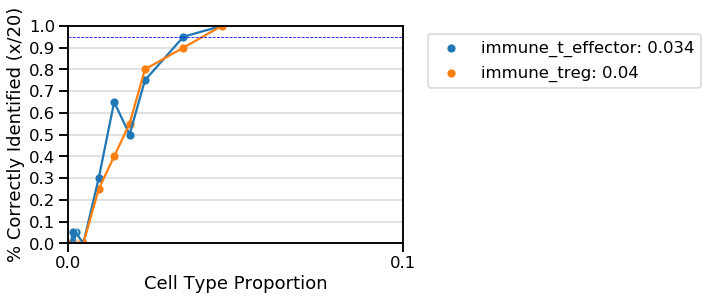

In [22]:
CELLTYPE_ATLAS_ = CELLTYPE_ATLAS
deconvolution_naive_ = deconvolution_naive
deconvolution_nnls_ = deconvolution_nnls
TRUE_PROPORTIONS = teff_titrating_proprotions

data = []
lod95_value = []

# <- start loop
for celltype in CELLTYPE_ATLAS_:
    
    CELL_TYPE = celltype

    celltype_idx = CELLTYPE_ATLAS_.index(CELL_TYPE)
    testing = deconvolution_nnls_[celltype_idx]

    ###### ----- correct proportion
    # detect with close to true proportion
    EPS = TITRATION_LIST

    p_correct = []

    testing = deconvolution_nnls_[celltype_idx]

    for i in range(0,len(testing)):
        df = testing[i]
       #  print(df.head())
        m, n = df.shape
        eps = EPS[i] * 0.3
        true_p = TRUE_PROPORTIONS[i]
        true_p_min = true_p - eps 
        true_p_max = true_p + eps
        phat = df[df.index == CELL_TYPE]
        phat = phat.values.squeeze()
        phat_boolean = [(true_p_min <= x <= true_p_max) for x in phat]
        p_correct.append(sum(phat_boolean) / n)


#     DETECTION_THRESHOLD = 0.01

#     p_detect = []

#     for df in testing:
#         m, n = df.shape
#         phat = df[df.index == CELL_TYPE]
#         phat_boolean = phat > DETECTION_THRESHOLD
#         p_detected = sum(phat_boolean.values.squeeze()) / n
#         p_detect.append(p_detected)

#     p_correct = p_detect


    ###### ----- plotting

    # Replace these with your data
    x_values = TRUE_PROPORTIONS
    y_values = p_correct  #  p_correct #
    
    data.append((x_values, y_values))

    # Sorting the x_values and y_values in the order of x_values
    sorted_indices = np.argsort(x_values)
    x_values_sorted = np.array(x_values)[sorted_indices]
    y_values_sorted = np.array(y_values)[sorted_indices]
    
    print(x_values_sorted)
    print(y_values_sorted)
    
    if x_values_sorted[0] == 0:
        y_values_sorted[0] = 0

    # Interpolating to find the x-value
    y_target = 0.95
    x_target = np.interp(y_target, y_values_sorted, x_values_sorted)
    lod95_value.append(x_target)



for i, (x_values, y_values) in enumerate(data):
    name = CELLTYPE_ATLAS_[i]
    lod95 = round(lod95_value[i], 3)
    label = f'{name}: {lod95}'
    if x_values[-1] == 0:
        y_values[-1] = 0
    sns.scatterplot(x=x_values, y=y_values, label=label)
    sns.lineplot(x=x_values, y=y_values)

# Set the limits and spacing of the x and y axes
plt.xticks(ticks=[i/10 for i in range(11)])
plt.yticks(ticks=[i/10 for i in range(11)])
plt.xlim(0, 0.1)
plt.ylim(0, 1)

plt.axhline(y=y_target, xmin=0, xmax=x_target+1, color='blue', linestyle='--', linewidth=0.8)

plt.grid(True, alpha=0.5)
plt.gca().set_axisbelow(True)

plt.xlabel('Cell Type Proportion')
plt.ylabel('% Correctly Identified (x/20)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()